In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [16]:
c_list = []
with open('./small_shaketext_13300.txt') as f:
    while True:
        c = f.read(1)
        if not c:
            break
        if c not in c_list:
            c_list.append(c)
            #c_list.append(c.upper())
            #c_list.append(c.lower())
            #c_list += str(c)
c_string = ""
for c in c_list:
    c_string += str(c)
c_string+=string.printable

all_chars       = c_string#string.printable
n_chars         = len(all_chars)
file            = open('./small_shaketext_13300.txt').read() #change if image captioning
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1030816
All possible characters: First Czen:
Bfowpcdayuh,mk.AlSYv?RMW'LINg;b!OjV-THEUDPqxJGKQ&ZX={|}*[](Ã¡)Î¸·½±¼ÏŒ‚/53041%98672©#â€™­¶µ³<>"”+_Â»“°Åœ\É¹ÌªËˆ¤§£	^Ä›$¥´ìÙ¨Ø…†×¦–˜•ÐÑ‡Š¿¯¬„«‘áƒëŸí¾ãš²àé®º‰~æçå¢Û‹Žè—žÊ@0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 286


In [18]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

#change if image captioning
# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [19]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [20]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        #self.rnn = nn.RNNCell(self.input_size, self.hidden_size) #change this to LSTM to GRU
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, 2)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        #hidden = self.rnn(input,hidden)###### To be filled ######
        #print(input.shape)
        #print(hidden.shape)
        output,(h0,c0) = self.rnn(input,hidden)
        hidden = (h0,c0)
        #output =self.linear(hidden) ###### To be filled ######
        output = self.linear(output)
        #print(self.output.size)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return (torch.zeros(2, 1,self.hidden_size).to(device),torch.zeros(2, 1,self.hidden_size).to(device)) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): LSTM(286, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=286, bias=True)
)

#### Training Step and Evaluation Step

In [21]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    #for t in range(seq_len):    # For each one in the input sequence.
   # print("target.shape")
    #print(target.shape)
    output, hidden = net(input, hidden)
    output = output.reshape(seq_len,-1)
    target = target.reshape(-1)
    
    #print("target.shape")
    #print(target.shape)
    #print("output.shape")
    #print(output.shape)
    
    loss += loss_func(output, target)

    loss.backward()             # Backward.  #comment if not update model
    opt.step()                  # Update the weights. #comment if not update model

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [22]:
# Evaluation step function.
def eval_step(net, init_seq='F', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    #for t in range(len(init_seq) - 1):
    #output, hidden = net(init_input, hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input
    
    #print(output.shape)
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        
        output, hidden = net(input, hidden)
        
        # Get the current output and hidden state.
        #output_t = output[t]
        
        #output, hidden = net(input[t].reshape(, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char).to(device)

    return predicted_seq

#### Training Procedure

In [23]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.02953234687447548
generated sequence: F& uuForICss.{s 
, o	Sp'ee.
camobefea u ns
RmnhoAa 
:Eaeitt osd_A ceRAdggEpne;ehnl. l)t,i dce*)ei	yuc

iter:199/15000 loss:0.028663579374551773
generated sequence: FN-Acµe.i.eefScN co!tK_eÏpt[DtritCOI
lno  s:.t.Alaeunyuhn
uK _]n_ !ielsttulnEOl
eoh|;	ltsl
bgmhe:nsUT

iter:299/15000 loss:0.028545737266540527
generated sequence: Fgyne i S
sa tlgiicmsIGt  tecnmult dl:wol(au0Gsso*0NpnrI u*ynm EoD,es	]e i[a   .nspE*eni:srs*sTnIraeR

iter:399/15000 loss:0.02816762775182724
generated sequence: F s=ie]mn _ishB r¯q!g saiiissb)dsfuesbhtenrehi  ni (c
n ekod ,ehuu t m ,Sr, q(f tue i - eaieTtens.dlE

iter:499/15000 loss:0.027796568349003792
generated sequence: Fbit [i 1wa7n S_Drehco  0N		;hms EC
RDa
ussnlaon mnk&g'twr toim.fslrlaraSaanoom_rls
uuwf ieol (O)

am

iter:599/15000 loss:0.025530338287353516
generated sequence: Funucvan
asmrgr.anrfs_fo)sp nlvec:t_Iwi.)=I*|
}ucachountavuv o|the_|t-ylgow,iglanewi diagtlt gioby me

iter:699/15000 loss

#### Training Loss Curve

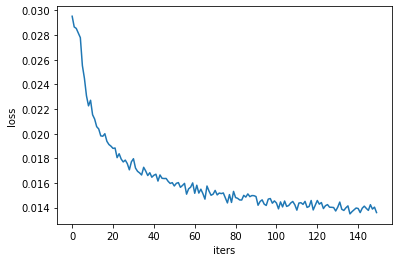

In [24]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [25]:
print(eval_step(net, predicted_len=600))

F[high_mags & that &quot;Tmemans_opdrach(internize (nlidopograunt the work 18 1 his Animasoc Sharling arown, in normable tod of either.

CORIOLANUS:
Cort part pos, you he, you chay.

Metay him guring intelly to hear may, no,
Till you love of detafliciance stan skely Darciliculy down:
I do't concrang resulting do my.

Forth may be is
will spayet Eshmusted lick you it, he make's small your proteen carl Aphiin I can thereforeing here if therefores' the have the fack, corators reflofactiongy,
And the World. COMING HARD:
And to be his into the hotess popules.
More tarnens,
I wall patcoul, come yours


In [ ]:
#I have two models
#testing when comparing two models: retrain the same datasets on the new_train_method where update model is commented, compare the loss of model1 and model2, greater = bad 

In [ ]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0